<div style="text-align: center;">
    <h1> <font style="bold"> TD VI: Inteligencia Artificial </font></h1>
    <h2><font style="bold">Trabajo práctico 2 </font></h2>
    <h3><font style="bold">Integrantes:</font></h3>
</div>
<div style="display: flex; justify-content: center;">
    <h4><ul>
        <li>Noguera Azul</li>
        <li>Gonzalez Rocio</li>
        <li>Guledjian Patricio</li>
        </ul>
    </h4>
</div>

In [1095]:
import pandas as pd
import numpy as np
import gc
import math
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats
import pycircular
from datetime import datetime
from math import sin, cos, pi
from random import randint, uniform
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import xgboost as xgb
from matplotlib import pyplot
import networkx as nx


In [1096]:
# Load the competition data
df = pd.read_csv("competition_data.csv")

In [1097]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199972 entries, 0 to 199971
Data columns (total 57 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   accepts_mercadopago                199972 non-null  bool   
 1   available_quantity                 199972 non-null  int64  
 2   avg_gmv_item_domain_30days         195607 non-null  float64
 3   avg_gmv_item_sel                   195607 non-null  float64
 4   avg_gmv_seller_bday                195607 non-null  float64
 5   avg_qty_orders_item_domain_30days  195607 non-null  float64
 6   avg_qty_orders_item_sel_30days     195607 non-null  float64
 7   avg_si_item_sel_30day              195607 non-null  float64
 8   benefit                            199971 non-null  float64
 9   boosted                            199972 non-null  bool   
 10  category_id                        199972 non-null  object 
 11  conversion                         1807

# Análisis Exploratorio de Datos

## Análisis de las variables numéricas

Comenzaremos analizando las variables numéricas que podrían no aportarnos valor a la predicción del modelo. 

In [1098]:
df_num = df.select_dtypes(include='number')
df_bool = df.select_dtypes(include='bool')

In [1099]:
x = df[["boosted", "accepts_mercadopago", "etl_version"]]  
for column in df_bool:  
   print(column) 
   print(df_bool[column].nunique())
   print("\t")

for column in df_num:  
   print(column) 
   print(df_num[column].nunique())
   print("\t")

accepts_mercadopago
1
	
boosted
1
	
free_shipping
2
	
fulfillment
2
	
available_quantity
6937
	
avg_gmv_item_domain_30days
17727
	
avg_gmv_item_sel
18652
	
avg_gmv_seller_bday
18634
	
avg_qty_orders_item_domain_30days
16760
	
avg_qty_orders_item_sel_30days
15129
	
avg_si_item_sel_30day
15527
	
benefit
2
	
conversion
2
	
health
35
	
product_id
4440
	
offset
209
	
original_price
6469
	
price
6029
	
print_position
10902
	
qty_items_dom
4193
	
qty_items_sel
1462
	
sold_quantity
5718
	
total_asp_item_domain_30days
17729
	
total_asp_item_sel_30days
18651
	
total_gmv_domain_bday
17717
	
total_gmv_item_30days
45132
	
total_items_domain
10309
	
total_items_seller
3240
	
total_orders_domain_30days
7882
	
total_orders_item_30days
635
	
total_orders_sel_30days
4413
	
total_si_domain_30days
9157
	
total_si_item_30days
850
	
total_si_sel_30days
5301
	
total_visits_domain
17646
	
total_visits_item
9618
	
total_visits_seller
17762
	
user_id
139110
	
ROW_ID
19211
	


Notamos que las variables *accepts_mercadopago* y *boosted* contienen un unico valor posible. Por lo que lo unico que le aportará al modelo es tiempo computacional, que no queremos!

Por otro lado, las variables *product_id* y *user_id* no las tendremos en cuenta porque en su mayor proporción se encuentran vacias y no aportan información a la predicción. 


In [1100]:
# %%capture
df = df.drop(columns=["product_id", "user_id", "accepts_mercadopago", "boosted"])

Para finalizar el apartado del analisis de variables numericas, nos gustaria agregar una nueva columna que creemos significativa para predecir la conversión. Notamos que tenemos dos variables *original_price* y *price*. El ratio de las mismas podría encontranse significativas, chequeemos...

In [1101]:
df["price_ratio"] = (df["original_price"] - df["price"]) / df["original_price"]

In [1102]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df['original_price'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 12282.229450137715
P-value: 0.0


Un valor alto de Chi-cuadrado indica una discrepancia significativa entre las variables. Además, el valor p es 0.0, lo que significa que la probabilidad de obtener un valor de Chi-cuadrado tan alto (o más alto) bajo la suposición de independencia es esencialmente nula. Esto proporciona una fuerte evidencia en contra de la hipótesis nula de independencia y sugiere que las variables están correlacionadas.

### Analisis de Nulos

Es importante destacar que notamos 4365 registros con muchas columnas nulas en nustro dataset. Algunos de estos registros estan presentes en la base de testing, por eso se decide no hacer estimaciones de estos valores ya que la base de testing es un reflejo de la realidad y no debería ser alterado. 

En el siguiente bloque de código se muestran los registros con columnas con gran proporcion de informacion nula...

In [1103]:
mask = df_num["avg_gmv_item_domain_30days"].isna()
del df_num
df[mask]

,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,category_id,conversion,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,warranty,ROW_ID,price_ratio
80,931,NaN,NaN,NaN,NaN,NaN,NaN,0.001,MLA9291,0.0,...,NaN,NaN,NaN,83887,321,36382,340b7d69-ee64-4dba-99c7-03066dbcb5f3,Garantía del vendedor: 30 días,NaN,0.150376
89,1000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,MLA417098,0.0,...,NaN,NaN,NaN,80838,19,6089,60f2a17a-5f37-4238-9b68-85c250bed879,Garantía del vendedor: 6 meses,NaN,0.219298
93,965,NaN,NaN,NaN,NaN,NaN,NaN,0.000,MLA1055,1.0,...,NaN,NaN,NaN,7997283,661,176129,028c9df1-483a-451f-b206-59d2b3aca377,NaN,NaN,0.090913
135,600,NaN,NaN,NaN,NaN,NaN,NaN,0.001,MLA30764,0.0,...,NaN,NaN,NaN,13523,187,49282,0615356b-9074-4852-b3de-abd937b17362,Sin garantía,NaN,0.299812
168,10,NaN,NaN,NaN,NaN,NaN,NaN,0.001,MLA414064,0.0,...,NaN,NaN,NaN,9608,32,3615,ad951016-9fe1-4724-8c53-b4c96f6626f2,Garantía de fábrica: 1 años,NaN,0.180899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199681,1,NaN,NaN,NaN,NaN,NaN,NaN,0.001,MLA120350,NaN,...,NaN,NaN,NaN,4120792,87,57957,45b4e692-868d-44b9-a9d7-27019e32b408,NaN,18920.0,0.500000
199697,1,NaN,NaN,NaN,NaN,NaN,NaN,0.001,MLA120350,NaN,...,NaN,NaN,NaN,8711980,28,57084,8ee8eb73-beb3-45f3-abb6-c30d36d92da7,NaN,18936.0,0.400000
199712,1,NaN,NaN,NaN,NaN,NaN,NaN,0.001,MLA372006,NaN,...,NaN,NaN,NaN,77042,9,27758,35d2fa9f-0a72-4a74-93bb-47d17fe3e397,1 año MAKITA Argentina,18951.0,0.230013
199856,700,NaN,NaN,NaN,NaN,NaN,NaN,0.000,MLA30100,NaN,...,NaN,NaN,NaN,102610,170,289510,21b5457b-48d3-4ffa-b7f8-a711de5cf8f8,Garantía del vendedor: 6 meses,19095.0,0.166806


Para que el analisis mantenga su consistencia se decide imputar los nulos presentados reemplazandolos por el valor promedio de la variable con los datos de entrenamiento. 
Las variables sobre las que se hara este proceso son:
- avg_gmv_item_domain_30days         
- avg_gmv_item_sel                  
- avg_gmv_seller_bday                
- avg_qty_orders_item_domain_30days  
- avg_qty_orders_item_sel_30days    
- avg_si_item_sel_30day 
- qty_items_dom                 
- qty_items_sel
- total_asp_item_domain_30days      
- total_asp_item_sel_30days     
- total_gmv_domain_bday            
- total_gmv_item_30day
- total_orders_domain_30days   
- total_orders_item_30days         
- total_orders_sel_30days      
- total_si_domain_30days         
- total_si_item_30days        
- total_si_sel_30days

In [1104]:
# Valores Medios
columnas = ['avg_gmv_item_domain_30days', 'avg_gmv_item_sel','avg_gmv_seller_bday', 'avg_qty_orders_item_domain_30days', 'avg_qty_orders_item_sel_30days',    
            'avg_si_item_sel_30day', 'qty_items_dom', 'qty_items_sel', 'total_asp_item_domain_30days', 'total_asp_item_sel_30days',     
            'total_gmv_domain_bday', 'total_gmv_item_30days', 'total_orders_domain_30days', 'total_orders_item_30days', 'total_orders_sel_30days',      
            'total_si_domain_30days', 'total_si_item_30days', 'total_si_sel_30days','benefit']
for columna in columnas:
    df[columna] = df[columna].fillna(df[df["ROW_ID"].isna()][columna].mean())

Ya no hay registros con valores nulos.

In [1105]:
mask = df["avg_gmv_item_domain_30days"].isna()
df[mask]

,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,category_id,conversion,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,warranty,ROW_ID,price_ratio


## Análisis las variables categoricas

In [1106]:
df_categoricas = df.select_dtypes(include='object')

In [1107]:
for column in df_categoricas:  
   print(column) 
   print(df_categoricas[column].nunique())
   print("\t")

category_id
2284
	
date
31
	
deal_print_id
196744
	
domain_id
1742
	
etl_version
1
	
full_name
2280
	
is_pdp
2
	
item_id
27695
	
listing_type_id
2
	
logistic_type
7
	
main_picture
26961
	
platform
4
	
print_server_timestamp
196780
	
site_id
1
	
tags
1227
	
title
26745
	
uid
159996
	
warranty
1288
	


#### Primer Analisis

- Se eliminan las variables de id (category_id, deal_print_id, domain_id, item_id) del analisis: no son representativas para la prediccion.
- se separan las variables temporales (date, print_server_timestamp) para analisis posterior.
- se elimina las variables etl_version, site_id al tener solo una categoria.
- se elimina las variables full_name, main_picture, tags, title, uid y warranty porque no es representativa.
- is_pdp, listing_type_id, logistic_type y platform pueden resultar interesantes para el analisis.
  
Procedemos a analizar las variables: is_pdp, listing_type_id y logistic_type.

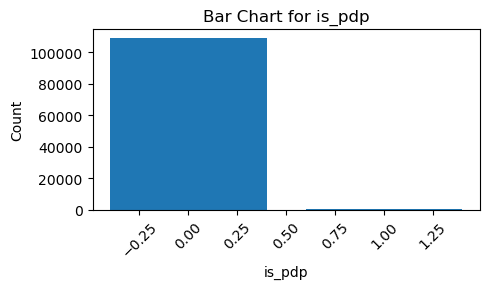

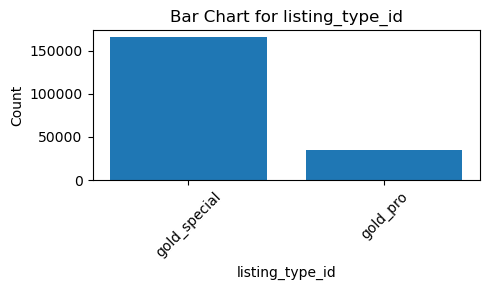

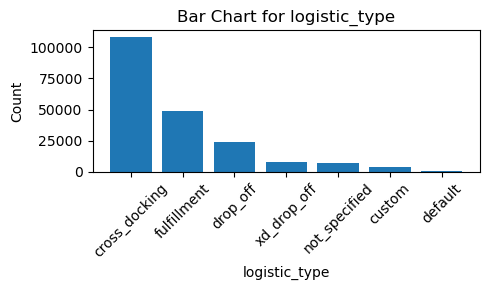

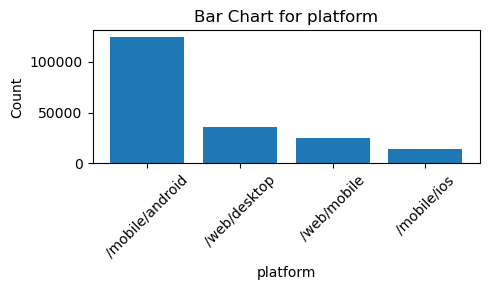

In [1108]:
# Analicemos las variables no numericas de nuestro Dataset
df_categoricas = df_categoricas[["is_pdp","listing_type_id","logistic_type", "platform"]]

# Iterar a través de las columnas categóricas y crear un gráfico de barras para cada una
for column in df_categoricas:  
    categories = df_categoricas[column].value_counts().index
    values = df_categoricas[column].value_counts().values
    

    plt.figure(figsize=(5, 3))  # Tamaño del gráfico (opcional)
    plt.bar(categories, values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Bar Chart for {column}')
    plt.xticks(rotation=45)  # Rotar etiquetas si son largas
    plt.tight_layout()  # Ajustar el diseño
    plt.show()

#### Segundo Análisis:


- is_pdp presenta valores nulos tanto en train como en test, por lo que se decide imputarlos. Se tomaran los registros nan como un posible valor y para normalizar la variable se utiliza One Hot Encoding. Como resultado, se agregaran dos columnas, ya que la tercera se da por entendida cuanda ambas sean falsas.
- listing_type se transforma a una variable booleana que es 1 cuando el listing es gold_special
- Se cree que el tipo de logistica no tiene una relacion natural con la variable resultado. Uno no decide si hacer una compra o no segun el tipo de logistica que utilice el comerciante para transportar su producto. Pero se procede a evaluar si existe una correlacion empirica. En caso de no haberla, se descartara la variable del analisis. 
- Se realizara OneHotEncoding sobre la variable platform.   

In [1109]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df['logistic_type'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 761.455399863375
P-value: 3.269950268794381e-161


Como resulta significativa la prueba de chi-cuadrado, se concluye que la variable logistic_type presenta una correlacion empirica. Es por eso que se decide hacer OneHotEncoding con la misma.

Realizamos one hot-encoding en la variable categoria *logistic_type* y *platform*.

In [1110]:
# One Hot-Encoding
df = pd.get_dummies(df, 
    sparse=True,
    columns=[
        "logistic_type", 
        "platform",
        "is_pdp"
    ],
    dtype=int
)

Convirtamos la variable categoria *listing_type_id* en booleana. Esta no presenta valores nulos. Si es gold_special será 1 y si es gold_pro será 0.

In [1111]:
df["listing_type_id"] = df["listing_type_id"].apply(lambda x: 1 if x == "True" else 0)

Para continuar con el analisis notamos que la variable *warranty* es de tipo objeto pero en realidad esta detallando si tiene garantia (cuanto tiempo) o no. Por lo tanto, intentaremos modificar esa variable y analizaremos la garantía de los productos tiene o no una correlación con la conversión. 

In [1112]:
df['warranty'].unique()

array(['Garantía de fábrica: 12 meses', nan,
       'Garantía de fábrica: 90 días', ..., '1 Año Garantia Oficial',
       '72 horas de prueba con Tecnofast', 'Garantia de por VIDA!'],
      dtype=object)

In [1113]:
# Define un diccionario de mapeo de unidades de medida
mapeo_unidades = {
    'Garantía de fábrica: 12 meses': 12,
    'Garantía de fábrica: 90 días': 3,
    '1 Año Garantia Oficial': 12,
    '72 horas de prueba con Tecnofast': 0,
    'Garantia de por VIDA!': 100,
}

# Aplica el mapeo a la columna 'warranty' usando la función map()
df['warranty'] = df['warranty'].map(mapeo_unidades)

# Corrige la línea para reemplazar los valores NaN en la columna 'warranty'
df['warranty'].fillna(0, inplace=True)


In [952]:
df['warranty'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 199972 entries, 0 to 199971
Series name: warranty
Non-Null Count   Dtype  
--------------   -----  
199972 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


Los valores de la variable *warranty* se verán de la siguiente manera con las modificaciones hechas:

In [955]:
df

,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,category_id,conversion,...,logistic_type_drop_off,logistic_type_fulfillment,logistic_type_not_specified,logistic_type_xd_drop_off,platform_/mobile/android,platform_/mobile/ios,platform_/web/desktop,platform_/web/mobile,is_pdp_False,is_pdp_True
0,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,MLA1055,0.0,...,0,0,0,0,0,0,1,0,1,0
1,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,MLA3724,0.0,...,1,0,0,0,1,0,0,0,1,0
2,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,MLA109282,0.0,...,0,1,0,0,1,0,0,0,1,0
3,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,MLA38493,0.0,...,0,1,0,0,0,0,0,1,1,0
4,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,MLA1694,0.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199967,63,84.123902,313.907255,533.642333,2.987805,6.941176,8.313725,0.001,MLA412631,NaN,...,0,1,0,0,1,0,0,0,1,0
199968,23256,393.334230,137.436786,256.548667,5.258486,8.517857,10.178571,0.001,MLA393757,NaN,...,0,0,0,0,0,0,0,1,1,0
199969,20,235.246741,327.451321,578.497333,5.096722,14.000000,16.358491,0.001,MLA3697,NaN,...,0,1,0,0,1,0,0,0,0,0
199970,45,53.861782,102.352949,266.117667,1.636275,3.807692,3.987179,0.001,MLA3422,NaN,...,1,0,0,0,1,0,0,0,1,0


Analicemos la correlación de la variable *warranty* con la variable *conversion*

In [893]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df['warranty'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 778.6829853012749
P-value: 9.05413640372007e-122


A partir de el analisis de correlación (Chi cuadrado) notamos que existe una asociación significativa entre las dos variables categóricas. Por lo que la utilizaremos en el modelo para estimar la probabilidad de conversion. 

### Tercer Analisis

La variable main_picture presenta la imagen del producto. Creemos relevante para la decision de compra el hecho de existir o no imagen. Por eso crearemos una variable booleana que describa esta situacion. 

In [894]:
 df["main_picture"].isna()

0          True
1         False
2         False
3         False
4         False
          ...  
199967    False
199968    False
199969    False
199970    False
199971    False
Name: main_picture, Length: 199972, dtype: bool

In [895]:
df["main_picture"] = df["main_picture"].apply(lambda x: 0 if pd.isna(x) else 1)

## Análisis de variables Temporales

Las variables temporales pueden influir mucho en el comportamiento del consumidor. Se debe evaluar y tener en cuenta el momento en el que estan visitando la pagina ya que puede determinar si se realiza o no la conversion. Es por eso que se realiza un encoding de estas variables.

In [896]:
# Modificamos el tipo de datos a datetime.
df["date"] = pd.to_datetime(df["date"])
df["print_server_timestamp"] = pd.to_datetime(df["print_server_timestamp"])
df[["date","print_server_timestamp"]]

,date,print_server_timestamp
0,2020-03-06,2020-03-06 00:19:30.735000-04:00
1,2020-04-01,2020-04-01 21:20:11.738000-04:00
2,2020-04-08,2020-04-08 18:38:48.360000-04:00
3,2020-04-25,2020-04-25 22:01:19.829000-04:00
4,2020-03-10,2020-03-10 13:20:56.633000-04:00
...,...,...
199967,2020-04-12,2020-04-12 14:35:44.784000-04:00
199968,2020-04-03,2020-04-03 17:32:53.035000-04:00
199969,2020-04-01,2020-04-01 22:51:08.898000-04:00
199970,2020-04-08,2020-04-08 11:32:27.563000-04:00


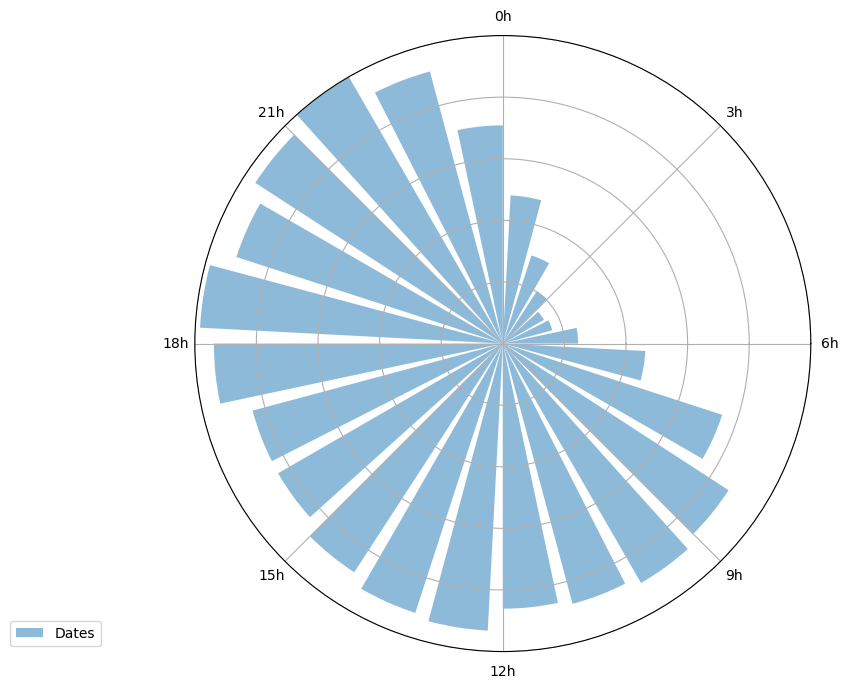

In [897]:
time_segment = 'hour'  
freq_arr, times = pycircular.utils.freq_time(df["print_server_timestamp"] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

Combinando las funciones seno y coseno podemos caracterizar una variable cíclica. Esto se simula de esta manera para que las variables tengan un sentido ciclico y no lineal. Por ejemplo, en el caso de las horas la hora 00 y la hora 23 en la realidad estan muy cerca una de la otra. Si se las analiza linealmente perderian esta propiedad, pero si se les hace un encoding calculando sus seno y coseno se mantendria. 
Se realizara este analisis con las horas, los dias de la semana y los dias del mes.
No se realiza sobre el mes porque solo hay dos meses.

Para las horas:

In [898]:
# Unidad de tiempo:
cantidad_tiempo = 24

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))

df['hour_sin'] = seno
df['hour_cos'] = coseno


Para los dias de la semana:

In [899]:
# Unidad de tiempo:
cantidad_tiempo = 7

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))

df['weekday_sin'] = seno
df['weekday_cos'] = coseno

Para los dias del mes:

In [900]:
# Como solo hay mes 3 y 4 aplicamos una regla para determinar la cantidad de dias en cada uno de los meses:
df["days_in_month"] = df["print_server_timestamp"].dt.month.apply(lambda x: 31 if x == 3 else 30)

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))
coseno = np.cos((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))

df['day_sin'] = seno
df['day_cos'] = coseno

df = df.drop(columns = ["days_in_month"])


In [901]:
df = df.drop(columns = ["date","print_server_timestamp"])

In [902]:
df.head()

,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,category_id,conversion,...,platform_/web/desktop,platform_/web/mobile,is_pdp_False,is_pdp_True,hour_sin,hour_cos,weekday_sin,weekday_cos,day_sin,day_cos
0,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,MLA1055,0.0,...,1,0,1,0,0.000000,1.000000e+00,-0.433884,-0.900969,0.937752,0.347305
1,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,MLA3724,0.0,...,0,0,1,0,-0.707107,7.071068e-01,0.974928,-0.222521,0.207912,0.978148
2,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,MLA109282,0.0,...,0,0,1,0,-1.000000,-1.836970e-16,0.974928,-0.222521,0.994522,-0.104528
3,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,MLA38493,0.0,...,0,1,1,0,-0.500000,8.660254e-01,-0.974928,-0.222521,-0.866025,0.500000
4,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,MLA1694,0.0,...,0,0,1,0,-0.258819,-9.659258e-01,0.781831,0.623490,0.897805,-0.440394


## Análisis de variables de texto

In [903]:
title = df['title']

# Exploración e Implementación del Modelo 

Una vez finalizado el analisis exploratorio de datos (EDA), se procede a la exploracion e implementacion del modelo.

- Train: 80%
- Val: 20%
- Test: de testeo.

In [786]:
# Split into training and evaluation samples
train_data = df[df["ROW_ID"].isna()]
test_data = df[df["ROW_ID"].notna()]
del(df)

In [787]:
train_data = train_data.select_dtypes(include='number')
train_data = train_data.drop(columns=["ROW_ID"])
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=["conversion"]), train_data['conversion'], test_size=0.2)
del train_data

In [788]:
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

In [789]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144608 entries, 77374 to 37346
Data columns (total 54 columns):
 #   Column                             Non-Null Count   Dtype           
---  ------                             --------------   -----           
 0   available_quantity                 144608 non-null  int64           
 1   avg_gmv_item_domain_30days         144608 non-null  float64         
 2   avg_gmv_item_sel                   144608 non-null  float64         
 3   avg_gmv_seller_bday                144608 non-null  float64         
 4   avg_qty_orders_item_domain_30days  144608 non-null  float64         
 5   avg_qty_orders_item_sel_30days     144608 non-null  float64         
 6   avg_si_item_sel_30day              144608 non-null  float64         
 7   benefit                            144608 non-null  float64         
 8   health                             144608 non-null  float64         
 9   listing_type_id                    144608 non-null  int64          

## XG Boost

### Prueba 1

Se realiza una primera prueba haciendo un unico job, pocas iteraciones y pocos splits en el cross validation con el fin de que demore poco y ver la performance rapidamente:

In [321]:
%%capture
model_xgb_1 = XGBClassifier(n_jobs=3, use_label_encoder=False)

In [322]:
%%capture
param_dist_1 = {'max_depth': stats.randint(1,20),
              'learning_rate': stats.uniform(0.01, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }
# Cross Validation
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

xgb_random_1 = RandomizedSearchCV(model_xgb_1,param_dist_1, cv=cv, verbose=1, n_jobs=1,scoring='roc_auc',n_iter=3,random_state=41)
xgb_random_1.fit(X_train,y_train)

Los siguientes parametros fueron los que mejor performance le dieron al modelo:

In [323]:
xgb_random_1.best_params_

{'colsample_bytree': 0.3509236237449401,
 'learning_rate': 0.03304791033630588,
 'max_depth': 17,
 'min_child_weight': 2,
 'n_estimators': 293,
 'subsample': 0.7005672374101258}

El siguiente valor representa la performance del modelo (con un unico job):

In [324]:
xgb_random_1.best_score_

0.8893385285695428

In [325]:
# Predict on the evaluation set
y_pred_1 = xgb_random_1.predict_proba(X_test)[:,1]
y_pred_1

array([0.01508414, 0.00284689, 0.13457522, ..., 0.00728381, 0.06400974,
       0.00151381], dtype=float32)

In [326]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_1})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.1.csv", sep=",", index=False)

<Figure size 1200x3000 with 0 Axes>

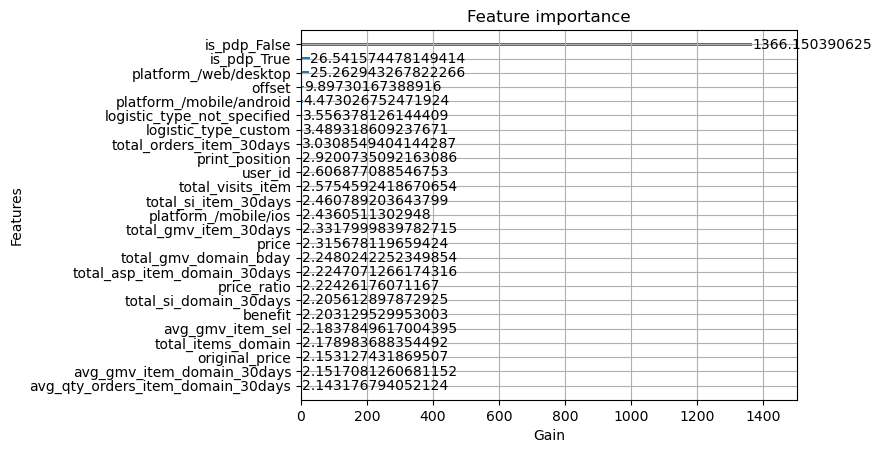

In [327]:

# Obtener el mejor modelo entrenado de tu RandomizedSearchCV
best_model_xgb_1 = xgb_random_1.best_estimator_

# Ajustar el tamaño del gráfico utilizando figsize
plt.figure(figsize=(12, 30))   # Ajusta el tamaño según tus preferencias

# Generar el gráfico de importancia
xgb.plot_importance(best_model_xgb_1, max_num_features=25,  importance_type="gain", xlabel="Gain")

# Mostrar el gráfico
plt.show()

### Prueba 2 (mejorando los parametros): 


In [866]:
%%capture
model_xgb_2 = XGBClassifier(n_jobs=3, use_label_encoder=False)

In [867]:
%%capture
param_dist_2 = {'max_depth': stats.randint(5,12),
              'learning_rate': stats.uniform(0.05, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

xgb_random_2 = RandomizedSearchCV(model_xgb_2,param_dist_2, cv=cv, verbose=1, n_jobs=5,scoring='roc_auc',n_iter=40,random_state=7)
xgb_random_2.fit(X_train,y_train)

In [868]:
xgb_random_2.best_params_
# {'colsample_bytree': 0.6132378121429716,
#  'learning_rate': 0.033917082477347975,
#  'max_depth': 7,
#  'min_child_weight': 3,
#  'n_estimators': 515,
#  'subsample': 0.8452823549192477}

{'colsample_bytree': 0.6011204636599379,
 'learning_rate': 0.08602556667988077,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 217,
 'subsample': 0.6277647948207705}

In [869]:
xgb_random_2.best_score_
# 0.8959785464016227
# 0.7838212950501537

0.8866185717271403

Iteraciones de el modelo que mejor performance tuvo:

In [870]:
for i, score in enumerate(xgb_random_2.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: auc_roc = {score:.4f}")

Iteraciones 1: auc_roc = 0.8695
Iteraciones 2: auc_roc = 0.8866
Iteraciones 3: auc_roc = nan
Iteraciones 4: auc_roc = 0.8825
Iteraciones 5: auc_roc = nan
Iteraciones 6: auc_roc = 0.8728
Iteraciones 7: auc_roc = 0.8605
Iteraciones 8: auc_roc = 0.8445
Iteraciones 9: auc_roc = 0.8777
Iteraciones 10: auc_roc = 0.8378
Iteraciones 11: auc_roc = 0.8354
Iteraciones 12: auc_roc = nan
Iteraciones 13: auc_roc = 0.8861
Iteraciones 14: auc_roc = 0.8853
Iteraciones 15: auc_roc = 0.8820
Iteraciones 16: auc_roc = 0.8639
Iteraciones 17: auc_roc = 0.8772
Iteraciones 18: auc_roc = 0.8785
Iteraciones 19: auc_roc = 0.8699
Iteraciones 20: auc_roc = 0.8690
Iteraciones 21: auc_roc = 0.8819
Iteraciones 22: auc_roc = nan
Iteraciones 23: auc_roc = 0.8761
Iteraciones 24: auc_roc = 0.8683
Iteraciones 25: auc_roc = 0.8232
Iteraciones 26: auc_roc = 0.8676
Iteraciones 27: auc_roc = nan
Iteraciones 28: auc_roc = 0.8627
Iteraciones 29: auc_roc = 0.8607
Iteraciones 30: auc_roc = 0.8327
Iteraciones 31: auc_roc = 0.8815
I

In [871]:
# Predict on the evaluation set
y_pred_2 = xgb_random_2.predict_proba(X_test)[:,1]
y_pred_2

array([3.77587602e-02, 1.29352513e-04, 1.60740316e-01, ...,
       1.97888119e-04, 1.19694605e-01, 4.81702591e-05], dtype=float32)

In [872]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_2})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.2.csv", sep=",", index=False)

#### Importancia de Variables

<Figure size 1200x3000 with 0 Axes>

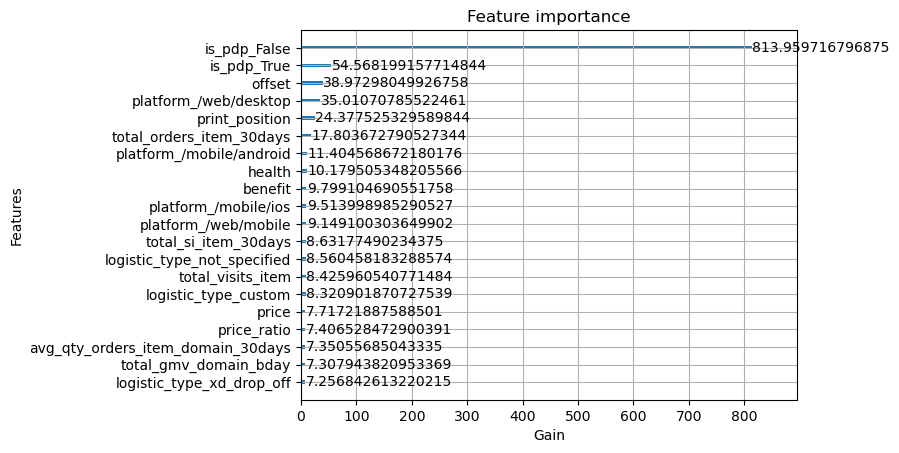

In [806]:

# Obtener el mejor modelo entrenado de tu RandomizedSearchCV
best_model_xgb = xgb_random_2.best_estimator_

# Ajustar el tamaño del gráfico utilizando figsize
plt.figure(figsize=(12, 30))   # Ajusta el tamaño según tus preferencias

# Generar el gráfico de importancia
xgb.plot_importance(best_model_xgb, max_num_features=20,  importance_type="gain", xlabel="Gain")

# Mostrar el gráfico
plt.show()

<span style="color:red">La performance del modelo con el 30% de los datos de test (public kaggle competition) dio como resultado: 0.88696</span>

### Prueba 3:

 Ahora utilicemos *early_stopping_rounds* a modo de que el modelo frene luego de que pasen 10 iteraciones en la que la performance no mejora. Este nos ayudará a intentar omitir el overfitting. 

In [336]:
%%capture
model_xgb_3 = XGBClassifier(n_jobs=3, use_label_encoder=False, early_stopping_rounds=10)

In [411]:
%%capture
# Definir la grilla de parámetros
param_grid = {
    'max_depth': [5, 6, 7], 
    'learning_rate': np.arange(0.05, 0.1),  
    # 'subsample': np.arange(0.1, 1.1), 
    # 'colsample_bytree': np.arange(0.3, 0.91, 0.1), 
    'min_child_weight': [2, 3], 
    'n_estimators': [400, 500, 800, 1000]  
}

# Crear una instancia de StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

# Crear una instancia de GridSearchCV con tu modelo
grid_search = GridSearchCV(model_xgb_3, param_grid, cv=cv, verbose=1, scoring='roc_auc')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train)

In [425]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 800}

In [426]:
grid_search.best_score_

0.8948503248079724

In [427]:
# Print the accuracy for each iteration
for i, score in enumerate(grid_search.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: roc_auc = {score:.4f}")

Iteraciones 1: roc_auc = 0.8924
Iteraciones 2: roc_auc = 0.8932
Iteraciones 3: roc_auc = 0.8943
Iteraciones 4: roc_auc = 0.8946
Iteraciones 5: roc_auc = 0.8925
Iteraciones 6: roc_auc = 0.8934
Iteraciones 7: roc_auc = 0.8944
Iteraciones 8: roc_auc = 0.8948
Iteraciones 9: roc_auc = 0.8935
Iteraciones 10: roc_auc = 0.8941
Iteraciones 11: roc_auc = 0.8949
Iteraciones 12: roc_auc = 0.8947
Iteraciones 13: roc_auc = 0.8937
Iteraciones 14: roc_auc = 0.8942
Iteraciones 15: roc_auc = 0.8945
Iteraciones 16: roc_auc = 0.8944
Iteraciones 17: roc_auc = 0.8946
Iteraciones 18: roc_auc = 0.8948
Iteraciones 19: roc_auc = 0.8944
Iteraciones 20: roc_auc = 0.8941
Iteraciones 21: roc_auc = 0.8943
Iteraciones 22: roc_auc = 0.8946
Iteraciones 23: roc_auc = 0.8943
Iteraciones 24: roc_auc = 0.8939


In [428]:
# Predict on the evaluation set
y_pred_3 = grid_search.predict_proba(X_test)[:,1]
y_pred_3

array([3.5815734e-02, 3.6029403e-05, 9.6014962e-02, ..., 5.1810421e-05,
       1.7267054e-01, 3.0102408e-05], dtype=float32)

In [429]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 800}

In [430]:
grid_search.best_score_

0.8948503248079724

In [431]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_3})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.3.csv", sep=",", index=False)

#### Grafico de performance

In [433]:
# Suponiendo que grid_search es tu objeto GridSearchCV ya entrenado

best_model = grid_search.best_estimator_  # Obtener el mejor modelo

# Entrenar el mejor modelo individualmente para obtener el historial de métricas
evals = [(X_train, y_train), (X_test, y_test)]  # Puedes ajustar esto a tus datos
best_model.fit(X_train, y_train, eval_metric="auc", eval_set=evals, verbose=True)

# Obtener el historial de métricas
train_history = best_model.evals_result()
epochs = len(train_history['validation_0']['auc'])
iterations = range(0, epochs)

# Ahora puedes trazar el historial de AUC-ROC
plt.plot(iterations, train_history["validation_0"]["auc"], label="training data")
plt.plot(iterations, train_history["validation_1"]["auc"], label="validation data")
plt.legend()
plt.ylabel('auc_roc')
plt.title('XGBoost auc_roc')
plt.show()


NameError: name 'y_test' is not defined

#### Importancia de Variables

<Figure size 1200x3000 with 0 Axes>

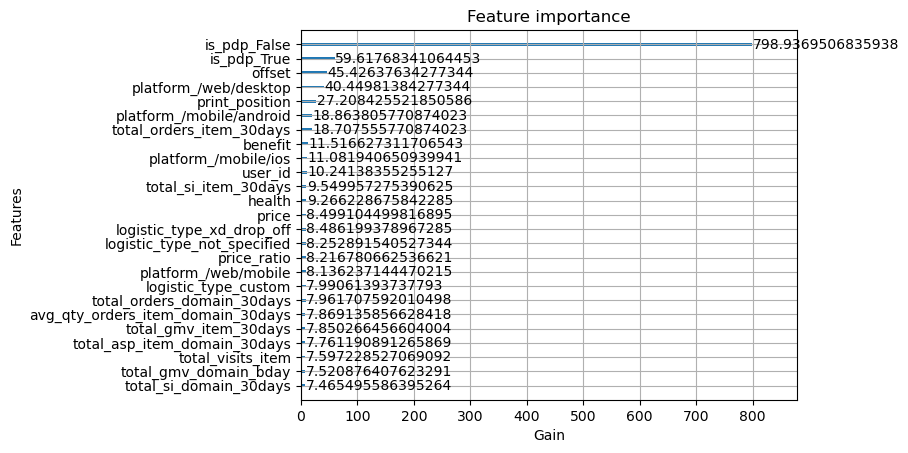

In [343]:

# Obtener el mejor modelo entrenado de tu RandomizedSearchCV
best_model_xgb = xgb_random_2.best_estimator_

# Ajustar el tamaño del gráfico utilizando figsize
plt.figure(figsize=(12, 30))   # Ajusta el tamaño según tus preferencias

# Generar el gráfico de importancia
xgb.plot_importance(best_model_xgb, max_num_features=25,  importance_type="gain", xlabel="Gain")

# Mostrar el gráfico
plt.show()

### Prueba 4

In [907]:
xgb1_fijo = xgb.XGBClassifier(
    objective = 'binary:logistic',
    random_state = 41,
    n_jobs=-1,
    colsample_bytree = 0.6132378121429716,
    learning_rate = 0.1,
    max_depth =7,
    min_child_weight = 3,
    n_estimators= 515,
    subsample= 0.8452823549192477
)

In [908]:
%%capture
xgb1_fijo.fit(X_train, y_train, early_stopping_rounds=15, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='auc', verbose=True)


Text(0.5, 1.0, 'XGBoost auc_roc')

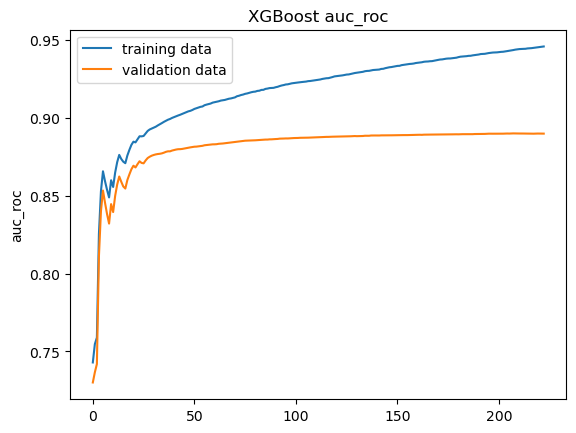

In [909]:
train_history = xgb1_fijo.evals_result()
epochs = len(train_history['validation_0']['auc'])
iterations = range(0, epochs)
plt.plot(iterations, train_history["validation_0"]["auc"], label="training data")
plt.plot(iterations, train_history["validation_1"]["auc"], label="validation data")
plt.legend()
pyplot.ylabel('auc_roc')
pyplot.title('XGBoost auc_roc')

In [863]:
xgb1_fijo.best_score

0.8900115314242865

In [864]:
# Predict on the evaluation set
y_pred_4 = xgb1_fijo.predict_proba(X_test)[:,1]
y_pred_4

array([2.4184896e-02, 7.6456214e-05, 1.7779899e-01, ..., 1.7099372e-04,
       1.3117617e-01, 4.4370980e-05], dtype=float32)

In [865]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_4})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xgb1_fijo.csv", sep=",", index=False)